In [1]:
#Add visulaizations to blog post and the heather meme. maybe transfer to a jupyter notebook slide show
#reword the middle section on p-value. 
# Importing necessary libraries and data
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,MultiComparison)
                                         
import sqlalchemy
from sqlalchemy import inspect
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker

engine = create_engine("sqlite:///northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()


inspector = inspect(engine)

# Get names of tables in database
print(inspector.get_table_names())

2019-04-12 21:24:07,472 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-12 21:24:07,473 INFO sqlalchemy.engine.base.Engine ()
2019-04-12 21:24:07,475 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-12 21:24:07,476 INFO sqlalchemy.engine.base.Engine ()
2019-04-12 21:24:07,480 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-12 21:24:07,481 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [9]:
#Hypothosis 1 
#Null Hypothosis Weekday Revenues = Weekend Revenues
#Alternative Weekend Revenues != Weekday Revenues
#Query Database and generated pandas dataframe
hype2_df = pd.read_sql_query("SELECT*FROM Employee e JOIN [Order] o ON o.EmployeeId = e.Id JOIN [OrderDetail] od ON od.OrderId = o.Id ", engine)
hype2_df['Revenue'] = hype2_df['UnitPrice']*hype2_df['Quantity']
hype2_df['WeekDay'] = pd.DatetimeIndex(hype2_df['OrderDate']).dayofweek
hype2_df.head()
stat_df = pd.concat([hype2_df['Id'],hype2_df['Revenue'],hype2_df['WeekDay']], axis =1)
stat_df['Employee_Id']= stat_df.iloc[:,0]
stat_df= stat_df.drop(['Id'], axis = 1)
stat_df.head()


2019-03-30 12:12:15,077 INFO sqlalchemy.engine.base.Engine SELECT*FROM Employee e JOIN [Order] o ON o.EmployeeId = e.Id JOIN [OrderDetail] od ON od.OrderId = o.Id 
2019-03-30 12:12:15,080 INFO sqlalchemy.engine.base.Engine ()


,Revenue,WeekDay,Employee_Id
0,168.0,2,5
1,98.0,2,5
2,174.0,2,5
3,167.4,3,6
4,1696.0,3,6


In [10]:
#Divide Up Days of the week into own series and then combine Weekdays and Weekend
monday_df = stat_df.loc[stat_df['WeekDay']==0]
tues_df = stat_df.loc[stat_df['WeekDay']==1]
weds_df = stat_df.loc[stat_df['WeekDay']==2]
thurs_df = stat_df.loc[stat_df['WeekDay']==4]
weekday_df =pd.concat([monday_df, tues_df, weds_df] , join = "inner")

weekn_df = stat_df.loc[stat_df['WeekDay']==6]
list_of_dfs = {'Monday':monday_df, 'Tuesday' :tues_df,'Wednesday':weds_df,'Thursay':thurs_df,'Weekday':weekday_df,'Weekend':weekn_df}
for key , column in list_of_dfs.items():  
    Revenue =column['Revenue'].sum()
    Mean = column['Revenue'].mean()
    Mean = Mean -Mean%.2
    Count = column['Revenue'].count()
    print(f' {key} : Total Revenue {Revenue}, Average {Mean}, Orders {Count}')
weekday_df.head()

 Monday : Total Revenue 272113.27, Average 640.2, Orders 425
 Tuesday : Total Revenue 266551.52, Average 593.6, Orders 449
 Wednesday : Total Revenue 256143.26, Average 587.4, Orders 436
 Thursay : Total Revenue 0.0, Average nan, Orders 0
 Weekday : Total Revenue 794808.05, Average 606.6, Orders 1310
 Weekend : Total Revenue 275256.9, Average 660.0, Orders 417


,Revenue,WeekDay,Employee_Id
11,2592.0,0,4
12,50.0,0,4
13,1088.0,0,4
26,877.5,0,4
27,86.4,0,4


In [11]:
#Sample both weekdays and weekends to compare simalar size populations

lts_wkd_samples = []
lts_wkn_samples = []
lst_both = []
for i in range(1000):
    wkd_sample = weekday_df['Revenue'].sample(n= 50, random_state = i)
    lts_wkd_samples.append(sum(wkd_sample)/ len(wkd_sample))
    wkn_sample = weekn_df['Revenue'].sample(n=50, random_state =i)
    lts_wkn_samples.append(sum(wkn_sample)/len(wkn_sample))
    lst_both.append((sum(wkn_sample)+sum(wkd_sample)) / (len(wkn_sample) +len(wkd_sample )))



In [12]:
tstat, pval = stats.ttest_ind(lts_wkd_samples,lts_wkn_samples)
print(f'The p-value of {pval} is far below the threshold 0.5 of having occurred ')
print(f'by chance. Here the a sample of weekend was compared to the weekday sample.')



The p-value of 4.938409112500616e-14 is far below the threshold 0.5 of having occurred 
by chance. Here the a sample of weekend was compared to the weekday sample.


/Users/edbeck/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


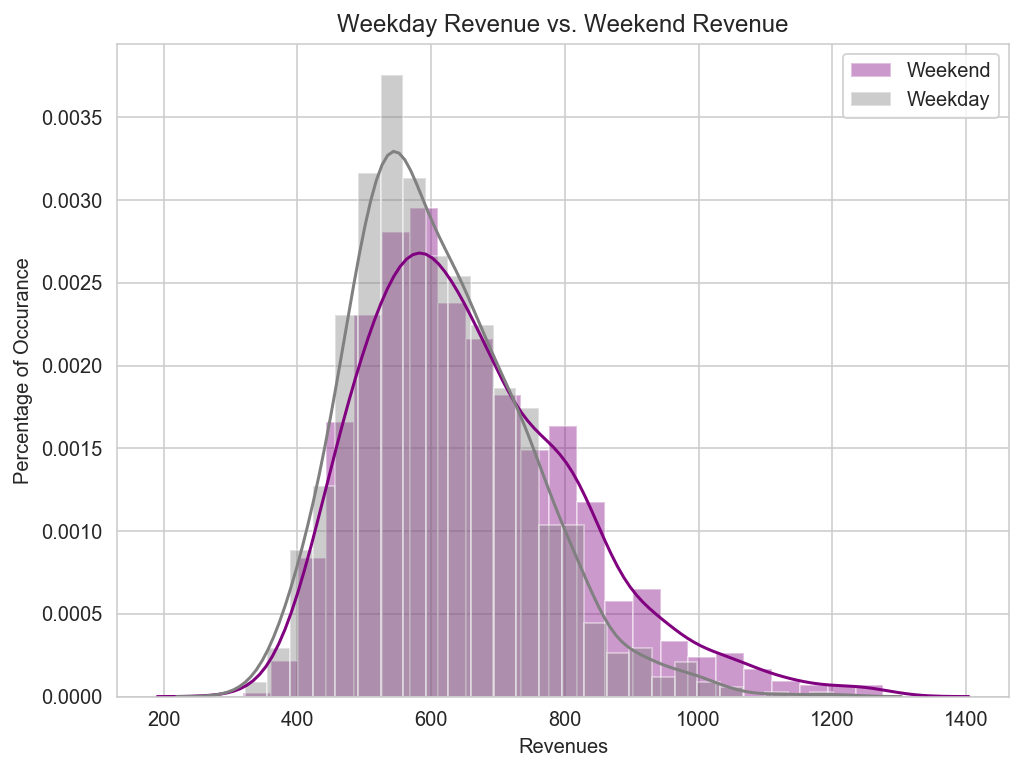

In [13]:
#Plot Sample Sets
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,6))
sns.distplot(lts_wkn_samples , label = 'Weekend', color = 'purple')
sns.distplot(lts_wkd_samples, label = 'Weekday', color = 'gray' ) 
plt.title('Weekday Revenue vs. Weekend Revenue')
plt.legend()
plt.ylabel('Percentage of Occurance')
plt.xlabel('Revenues')
plt.show()



In [11]:
# Hypothosis 2  
#Revenues_Discount  = Quantity * UnitPrice - Discount*Quantity*UnitPrice , Revenue_Flat = Quantity*UnitPrice
# Null Hypothosisn Revenue_Flat > Revenue_Discount
#Alternative Hypothosis Discounts lead to greater revenues
#Made a plot of Revenue with Discount and Compared to Revenue Without Discount
dis_df = pd.read_sql_query("SELECT Quantity, UnitPrice,  Discount FROM [OrderDetail] WHERE Discount > 0 ORDER BY Discount DESC " , engine)
dis_df['Rev_Discount'] = dis_df.Quantity * dis_df.UnitPrice - dis_df.Discount*dis_df.Quantity * dis_df.UnitPrice
flat_df = pd.read_sql_query("SELECT Quantity, UnitPrice,  Discount FROM [OrderDetail] WHERE Discount = 0.0 ORDER BY Discount DESC " , engine)
flat_df['Rev_Flat'] = flat_df.Quantity * flat_df.UnitPrice 



2019-04-12 17:53:56,127 INFO sqlalchemy.engine.base.Engine SELECT Quantity, UnitPrice,  Discount FROM [OrderDetail] WHERE Discount > 0 ORDER BY Discount DESC 
2019-04-12 17:53:56,132 INFO sqlalchemy.engine.base.Engine ()
2019-04-12 17:53:56,172 INFO sqlalchemy.engine.base.Engine SELECT Quantity, UnitPrice,  Discount FROM [OrderDetail] WHERE Discount = 0.0 ORDER BY Discount DESC 
2019-04-12 17:53:56,173 INFO sqlalchemy.engine.base.Engine ()


In [12]:
#Random Sampling of df's
discount_means = []
flat_means = []
for i in range(10**4):
    discount_sample = dis_df.sample(n=50, random_state=i) #Take a sample of 50 orders
    discount_means.append(discount_sample.Rev_Discount.mean()) #Calculate the sample mean
    flat_sample = flat_df.sample(n=50, random_state=i) 
    flat_means.append(flat_sample.Rev_Flat.mean())
dis_mean = round(sum(discount_means)/len(discount_means),0)
flat_mean = round(sum(flat_means)/len (flat_means) , 0)
print(f'Flat Revenues Mean = {flat_mean} Discount Revenues Mean {dis_mean}')

Flat Revenues Mean = 569.0 Discount Revenues Mean 613.0


In [13]:
#Queries of All Discounted Rates and Flat Rate 
dis_2_df = pd.read_sql_query("SELECT Quantity, UnitPrice,Discount FROM [OrderDetail] WHERE Discount = 0.05   " , engine)
dis_3_df = pd.read_sql_query("SELECT  Quantity, UnitPrice, Discount FROM [OrderDetail] WHERE Discount = 0.1   " , engine)
dis_4_df = pd.read_sql_query("SELECT Quantity, UnitPrice,  Discount FROM [OrderDetail] WHERE Discount = 0.15   " , engine)
dis_5_df = pd.read_sql_query("SELECT Quantity, UnitPrice,  Discount FROM [OrderDetail] WHERE Discount = 0.2   " , engine)
dis_6_df = pd.read_sql_query("SELECT Quantity, UnitPrice,   Discount FROM [OrderDetail] WHERE Discount = 0.25   " , engine)
dis_1_df = pd.read_sql_query("SELECT Quantity, UnitPrice,Discount FROM [OrderDetail] WHERE Discount =0.00   " , engine)
discount_df = pd.DataFrame()
dis_2_df.head()
def make_revenue (df):
    sample_mean = []
    df['Revenue'] = df['Quantity'] * df['UnitPrice'] - df['Discount']*df['Quantity'] * df['UnitPrice']
    df= df.drop(['Quantity', 'UnitPrice'], axis =1 )
    for i in range(10**4):
        discount_sample = df.Revenue.sample(n=50, random_state=i) #Take a sample of 50 orders
        sample_mean.append(discount_sample.mean()) #Calculate the sample mean
        
    return sample_mean
dis_2 = make_revenue(dis_2_df)
dis_3= make_revenue(dis_3_df)
dis_4= make_revenue(dis_4_df)
dis_5= make_revenue(dis_5_df)
dis_6= make_revenue(dis_6_df)
dis_1= make_revenue(dis_1_df)

2019-04-12 17:54:07,920 INFO sqlalchemy.engine.base.Engine SELECT Quantity, UnitPrice,Discount FROM [OrderDetail] WHERE Discount = 0.05   
2019-04-12 17:54:07,923 INFO sqlalchemy.engine.base.Engine ()
2019-04-12 17:54:07,932 INFO sqlalchemy.engine.base.Engine SELECT  Quantity, UnitPrice, Discount FROM [OrderDetail] WHERE Discount = 0.1   
2019-04-12 17:54:07,934 INFO sqlalchemy.engine.base.Engine ()
2019-04-12 17:54:07,941 INFO sqlalchemy.engine.base.Engine SELECT Quantity, UnitPrice,  Discount FROM [OrderDetail] WHERE Discount = 0.15   
2019-04-12 17:54:07,942 INFO sqlalchemy.engine.base.Engine ()
2019-04-12 17:54:07,950 INFO sqlalchemy.engine.base.Engine SELECT Quantity, UnitPrice,  Discount FROM [OrderDetail] WHERE Discount = 0.2   
2019-04-12 17:54:07,951 INFO sqlalchemy.engine.base.Engine ()
2019-04-12 17:54:07,962 INFO sqlalchemy.engine.base.Engine SELECT Quantity, UnitPrice,   Discount FROM [OrderDetail] WHERE Discount = 0.25   
2019-04-12 17:54:07,963 INFO sqlalchemy.engine.bas

In [14]:
t_stat, p = stats.ttest_ind(flat_means, discount_means)
p2 = round(p*2,3)

print(f'The Null Hypothosis was rejected for the average discount revenues were greater ')
print(f'than the flat rate with a p-value {p2},corresponding to the result being by ')
print('chance being less then a pre-established margin of error of 0.05')
print(' ')
discount_list = [dis_2, dis_3, dis_4, dis_5, dis_6]
discount_value = 0.05
for discount in discount_list:
    t_stat_sample, p_sample = stats.ttest_ind(dis_1, discount)
    p_value = p_sample*2 
    if p_value < 0.5:
        print(f'Null Hypothosis was rejected for discount value {discount_value} ,')
        print(f'p-value: {p_value}') 
    
    else:
        print(f'Null Hypothosis held for discount value {discount_value} results could have')
        print(f'occured by chance. p-valule {p_value}') 
    discount_value = round(discount_value + 0.05, 3)
print(' ')
print('The p-value was double due to the test being a two-sided but the Null Hypothosis ')
print('only being one-sided')

The Null Hypothosis was rejected for the average discount revenues were greater 
than the flat rate with a p-value 0.0,corresponding to the result being by 
chance being less then a pre-established margin of error of 0.05
 
Null Hypothosis was rejected for discount value 0.05 ,
p-value: 0.0
Null Hypothosis was rejected for discount value 0.1 ,
p-value: 5.280195826001065e-145
Null Hypothosis was rejected for discount value 0.15 ,
p-value: 1.573349378813915e-13
Null Hypothosis was rejected for discount value 0.2 ,
p-value: 3.600882547885897e-16
Null Hypothosis was rejected for discount value 0.25 ,
p-value: 0.0
 
The p-value was double due to the test being a two-sided but the Null Hypothosis 
only being one-sided


['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


/Users/edbeck/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


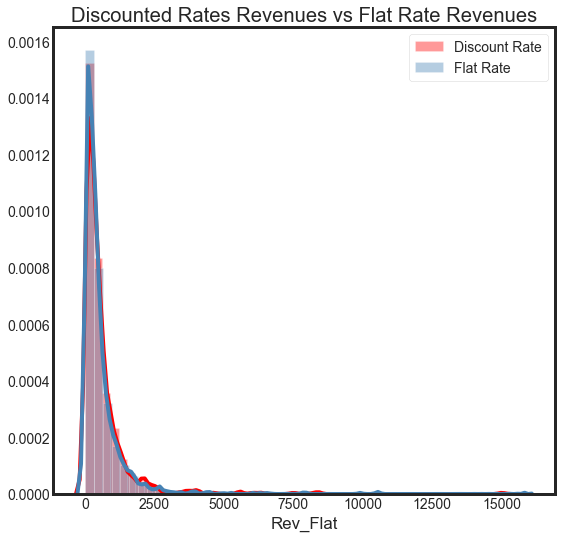

In [24]:
#Plot of Raw Data
print(plt.style.available)

fig = plt.figure(figsize=(8,8))
sns.set_style('whitegrid')
sns.set_style('ticks')
sns.distplot(dis_df.Rev_Discount ,color = 'red', label = 'Discount Rate')
sns.distplot(flat_df.Rev_Flat, color = 'steelblue', label = 'Flat Rate') 
plt.title('Discounted Rates Revenues vs Flat Rate Revenues')
plt.legend()
plt.show()


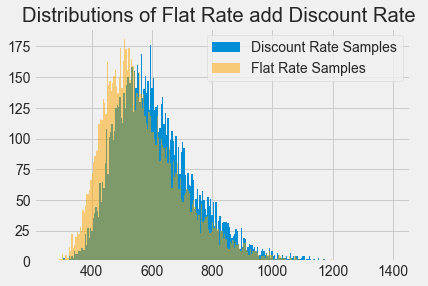

In [19]:
#Distribution of Entire Population
plt.style.use('fivethirtyeight') 
sns.despine()
plt.hist(discount_means, bins=250, lw = 0 , label = 'Discount Rate Samples')
plt.hist(flat_means,  bins=250, color = 'orange' ,alpha =0.5, lw =0, label = 'Flat Rate Samples')
plt.legend ()
plt.title('Distributions of Flat Rate add Discount Rate ')
plt.show()

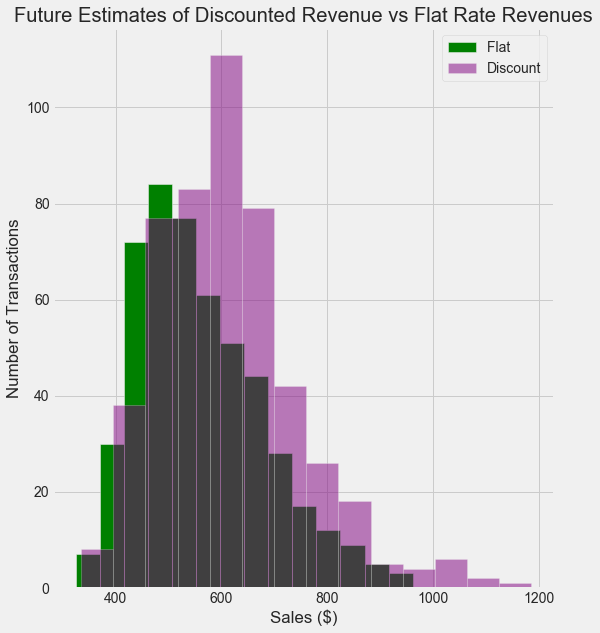

In [20]:
# Small 1000 count average transactions of equal Discounted Rate and Flat Rate for Visualization
# Discounted Rates are random mix of all percentages 
np.random.seed(100)
sample_size = 500

discount_sample = np.random.choice(a= discount_means, size=500)                              
discount_sample_mean = discount_sample.mean()
discount_sample_std = discount_sample.std()

flat_sample = np.random.choice(a= flat_means,size=500)                              
flat_sample_mean = flat_sample.mean()
flat_sample_std = flat_sample.std()

fig = plt.figure(figsize=(8,9.6))
plt.hist(flat_sample, bins = 14,label = 'Flat ', color = 'green')
plt.hist(discount_sample, bins =14, label = 'Discount',color = 'purple', alpha =0.5)
npflat_means = np.array(flat_means)
npdis_means = np.array(discount_means)

plt.title('Future Estimates of Discounted Revenue vs Flat Rate Revenues')
plt.xlabel('Sales ($)')
plt.ylabel('Number of Transactions')
plt.legend()
plt.show()

2019-03-30 12:13:32,328 INFO sqlalchemy.engine.base.Engine SELECT Quantity, UnitPrice,Discount FROM [OrderDetail]    
2019-03-30 12:13:32,331 INFO sqlalchemy.engine.base.Engine ()


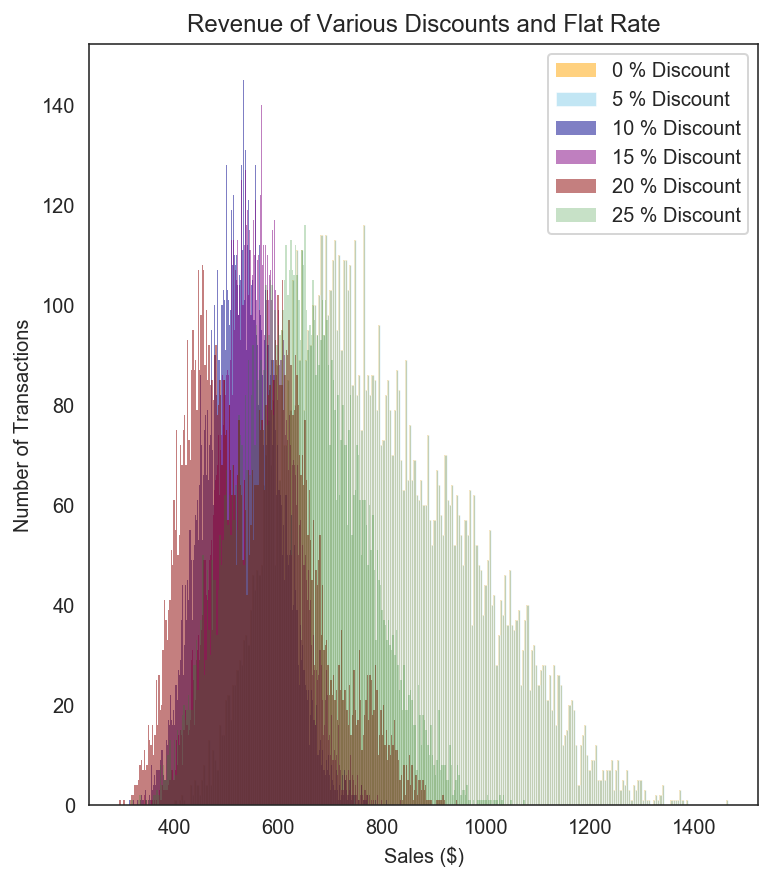

In [22]:
discount2_df = pd.read_sql_query("SELECT Quantity, UnitPrice,Discount FROM [OrderDetail]    " , engine)
discount2_df['Revenue'] = discount2_df['Quantity'] * discount2_df['UnitPrice']
discount2_df= discount2_df.drop(['Quantity', 'UnitPrice'], axis =1 )
discount2_df.head()
fig = plt.figure(figsize=(6,7))
ax = fig.gca()

ax =plt.hist(dis_2,bins= 250,  color = 'orange', lw = 0,alpha = 0.5, label = '0 % Discount' )
plt.hist(dis_2,bins= 250,  color = 'skyblue',alpha = .5, lw = .5, label = '5 % Discount')
plt.hist(dis_3,bins= 250,  color = 'darkblue', lw = 0,alpha = 0.5,  label = '10 % Discount')
plt.hist(dis_4,bins= 250,  color = 'purple', lw = 0,alpha = 0.5,  label = '15 % Discount')
plt.hist(dis_5,bins= 250,  color = 'darkred', lw = 0,alpha = 0.5,  label = '20 % Discount')
plt.hist(dis_6,bins= 250,  color = 'forestgreen', lw = 0,alpha = 0.25,  label = '25 % Discount')
plt.title('Revenue of Various Discounts and Flat Rate')

plt.xlabel('Sales ($)')
plt.ylabel('Number of Transactions')
plt.legend()
sns.set_style("white")
plt.show()

In [57]:
plt.style.use('seaborn-white')

<function matplotlib.pyplot.show(*args, **kw)>

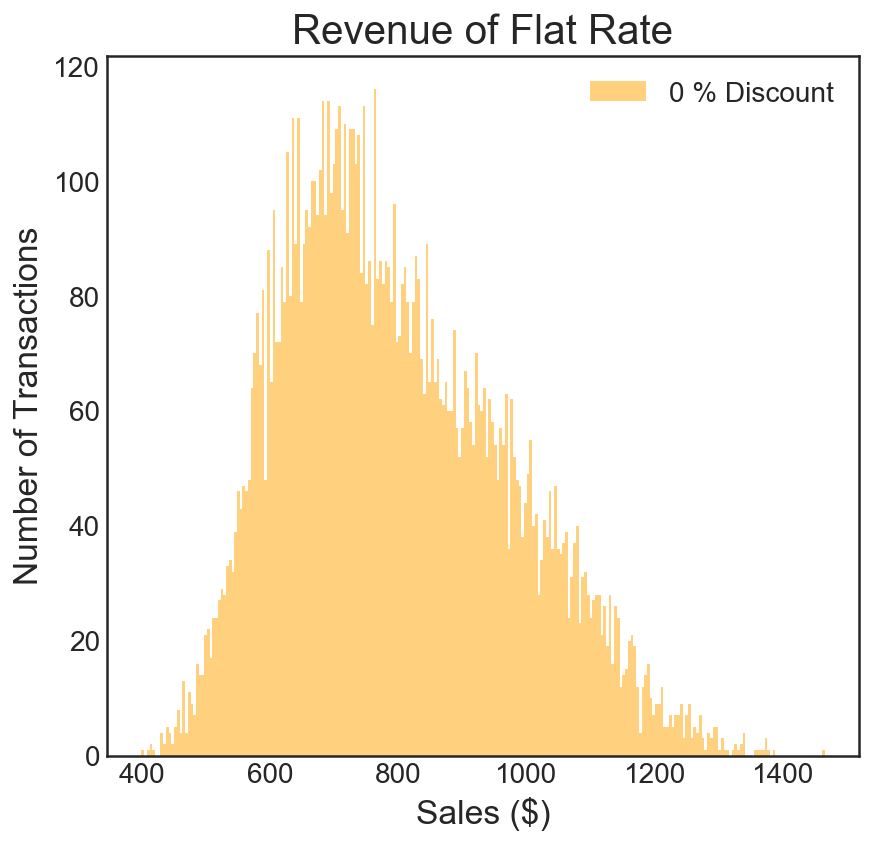

In [58]:

fig = plt.figure(figsize=(6,6))


plt.hist(dis_2,bins= 250,  color = 'orange', lw = 0,alpha = 0.5, label = '0 % Discount' )
plt.title('Revenue of Flat Rate')

plt.xlabel('Sales ($)')
plt.ylabel('Number of Transactions')
plt.legend()

plt.show

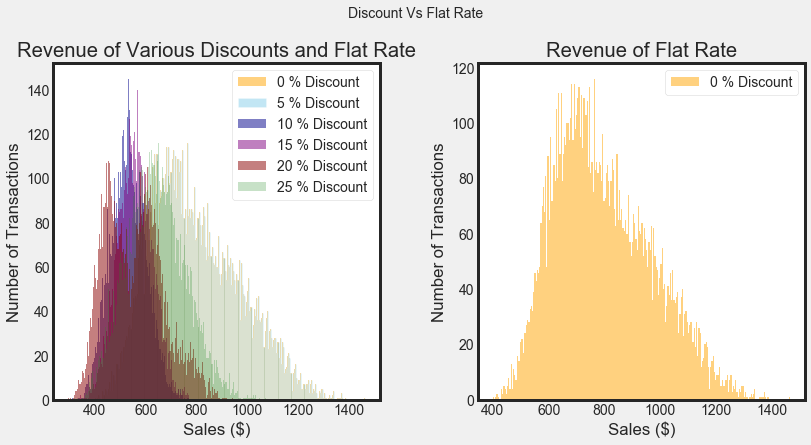

In [22]:
fig = plt.figure(figsize = (12,6))
sns.set_style("white")
title = fig.suptitle("Discount Vs Flat Rate", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1,2, 1)
ax = fig.gca()
ax =plt.hist(dis_2,bins= 250,  color = 'orange', lw = 0,alpha = 0.5, label = '0 % Discount' )
plt.hist(dis_2,bins= 250,  color = 'skyblue',alpha = .5, lw = .5, label = '5 % Discount')
plt.hist(dis_3,bins= 250,  color = 'darkblue', lw = 0,alpha = 0.5,  label = '10 % Discount')
plt.hist(dis_4,bins= 250,  color = 'purple', lw = 0,alpha = 0.5,  label = '15 % Discount')
plt.hist(dis_5,bins= 250,  color = 'darkred', lw = 0,alpha = 0.5,  label = '20 % Discount')
plt.hist(dis_6,bins= 250,  color = 'forestgreen', lw = 0,alpha = 0.25,  label = '25 % Discount')
plt.title('Revenue of Various Discounts and Flat Rate')
plt.xlabel('Sales ($)')
plt.ylabel('Number of Transactions')
plt.legend()

ax = fig.add_subplot(1,2, 2)
plt.hist(dis_2,bins= 250,  color = 'orange', lw = 0,alpha = 0.5, label = '0 % Discount' )
plt.title('Revenue of Flat Rate')
plt.xlabel('Sales ($)')
plt.ylabel('Number of Transactions')
plt.legend()

In [2]:
# Visualization of Total Sales of Each Country and Average Sale
h6 = pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id  ', engine)
h6['Revenue'] = h6.iloc[:,4]* h6.iloc[:,3]
h6_df = pd.DataFrame()
h6_df['Revenue']= h6['Revenue']
h6_df['Country'] =h6. iloc[:,-4]
h6 = pd.read_sql_query('SELECT  *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id ', engine)

list_of_countrys = ['France', 'Germany', 'Brazil', 'Belgium', 'Switzerland',
       'Venezuela', 'Austria', 'Mexico', 'USA', 'Sweden', 'Finland',
       'Italy', 'Spain', 'UK', 'Ireland', 'Portugal', 'Canada', 'Denmark',
       'Poland', 'Norway', 'Argentina']
h6_raw = pd.DataFrame()
h6_raw['Revenue'] = h6.iloc[:, 3]* h6.iloc[:,4]
h6_raw['Country '] = h6['Country']
h6_raw.shape
h6_df.Country.unique()
sum_rev_4_country = h6_df.groupby('Country')['Revenue'].sum()
count_country = h6_df.groupby('Country')['Revenue'].count()

list_of_countrys = ['France', 'Germany', 'Brazil', 'Belgium', 'Switzerland',
       'Venezuela', 'Austria', 'Mexico', 'USA', 'Sweden', 'Finland',
       'Italy', 'Spain', 'UK', 'Ireland', 'Portugal', 'Canada', 'Denmark',
       'Poland', 'Norway', 'Argentina']

big_bang = pd.DataFrame()
big_bang = pd.concat([count_country, sum_rev_4_country], axis = 1)
big_bang.head()
big_bang['Average Transaction'] =round( big_bang.iloc[:,1] / big_bang.iloc[:,0])
big_bang['Transaction'] = big_bang.iloc[:,0]
big_bang['Total \n Reveune \n'] = big_bang.iloc[:,1]
big_bang= big_bang.drop(['Revenue'], axis =1)

big_bang

2019-04-12 21:24:31,298 INFO sqlalchemy.engine.base.Engine SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id  
2019-04-12 21:24:31,303 INFO sqlalchemy.engine.base.Engine ()
2019-04-12 21:24:31,505 INFO sqlalchemy.engine.base.Engine SELECT  *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id 
2019-04-12 21:24:31,506 INFO sqlalchemy.engine.base.Engine ()


,Average Transaction,Transaction,Total Reveune
Country,,,
Argentina,203.0,23,4658.90
Austria,1116.0,125,139496.63
Belgium,627.0,56,35134.98
Brazil,520.0,163,84742.38
Canada,738.0,75,55334.10
Denmark,756.0,46,34782.25
Finland,366.0,54,19778.45
France,479.0,175,83882.86
Germany,746.0,328,244640.63


In [3]:
#Null Hypothosis Countries Average Transactions are equall
#Alternative Hypothosis Average Transactions will show large disparities
#Query All countries independently
h7 =  pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "France" ', engine)
h7['Revenue'] = h7.iloc[:,4]* h7.iloc[:,3]
h7_df = pd.DataFrame()
h7_df['Revenue']= h7['Revenue']
h7_df['Country'] =h7. iloc[:,-4]

h72 =  pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Austria" ', engine)
h72['Revenue'] = h72.iloc[:,4]* h72.iloc[:,3]
h72_df = pd.DataFrame()
h72_df['Revenue']= h72['Revenue']
h72_df['Country'] =h72. iloc[:,-4]
h_braz = pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Brazil" ', engine)
h_belg= pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Belgium" ', engine)
h_arg= pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Argentina " ', engine)
h_ger= pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Germany" ', engine) 
h_swit= pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Switzerland" ', engine) 
h_venz= pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Venezuela " ', engine) 
h_mex= pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Mexico" ', engine) 
h_usa= pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "USA" ', engine) 
h_swed = pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Sweden " ', engine) 
#h_fin = = pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Finland" ', engine)
h_itl = pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Italy" ', engine) 
h_spa = pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Spain" ', engine) 
h_uk = pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "UK" ', engine)
h_ire = pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Ireland" ', engine) 
h_canada = pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Canada" ', engine)
h_den = pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Denmark" ', engine) 
h_pol = pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Poland" ', engine)
h_nor = pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Norway" ', engine)
h_por= pd.read_sql_query('SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Portugal" ', engine) 

2019-04-12 21:24:35,689 INFO sqlalchemy.engine.base.Engine SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "France" 
2019-04-12 21:24:35,693 INFO sqlalchemy.engine.base.Engine ()
2019-04-12 21:24:35,722 INFO sqlalchemy.engine.base.Engine SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Austria" 
2019-04-12 21:24:35,723 INFO sqlalchemy.engine.base.Engine ()
2019-04-12 21:24:35,743 INFO sqlalchemy.engine.base.Engine SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Brazil" 
2019-04-12 21:24:35,745 INFO sqlalchemy.engine.base.Engine ()
2019-04-12 21:24:35,768 INFO sqlalchemy.engine.base.Engine SELECT *FROM [OrderDetail] od JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id WHERE country = "Belgium" 
2019-04-12 21:24:35,769 INFO sqlalch

In [4]:
#create useable dataframes 
def make_df (sql):
    sql['Revenue'] = sql.iloc[:,4]* sql.iloc[:,3]
    df = pd.DataFrame()
    df['Revenue']= sql['Revenue']
    df['Country'] =sql.iloc[:,-4]
    
    #sample = sampling(df.Revenue)
    return df 
france = make_df(h7)
argentina = make_df(h_arg)
austria = make_df(h72)
belgium = make_df(h_belg)
brazil = make_df(h_braz)
germany = make_df(h_ger)
switzerland = make_df(h_swit)
mexico = make_df(h_mex)
usa = make_df(h_usa)
sweden = make_df(h_swed)
spain = make_df(h_spa)
italy = make_df(h_itl)
uk = make_df(h_uk)
portugal = make_df(h_por)
canada = make_df(h_canada)
denmark = make_df(h_den)
poland = make_df(h_pol)
norway = make_df(h_nor)




,Revenue,Country


In [5]:
#Sample countries transactions to have equal sample sets

france_sampling = []
belgium_sampling = []
austria_sampling = []
brazil_sampling = []
switzerland_sampling = []
norway_sampling = []
mexico_sampling = []
usa_sampling = []
spain_sampling = []
italy_sampling = []
uk_sampling = []
portugal_sampling = []
canada_sampling = []
denmark_sampling = []
poland_sampling = []



for i in range(0,1000):
    np.random.seed(i)
    fra_sam = france.Revenue.sample(n=50, replace= True  )
    france_sampling.append(fra_sam.mean())
    bel_sam = belgium.Revenue.sample(n=50, replace= True  )
    belgium_sampling.append(bel_sam.mean())
    
    aus_sam = austria.Revenue.sample(n=50, replace= True  )
    austria_sampling.append(aus_sam.mean())
    baz_sam = brazil.Revenue.sample(n=50, replace= True  )
    brazil_sampling.append(baz_sam.mean())
    swit_sam = switzerland.Revenue.sample(n=50, replace= True  )
    switzerland_sampling.append(swit_sam.mean()) 
    mex_sam =mexico.Revenue.sample(n=50, replace= True  )
    mexico_sampling.append(mex_sam.mean()) 
    usa_sam =usa.Revenue.sample(n=50, replace= True  )
    usa_sampling.append(usa_sam.mean()) 
  
    spa_sam =spain.Revenue.sample(n=50, replace= True  )
    spain_sampling.append(spa_sam.mean()) 
    itl_sam =italy.Revenue.sample(n=50, replace= True  )
    italy_sampling.append(itl_sam.mean())
    uk_sam =uk.Revenue.sample(n=50, replace= True  )
    uk_sampling.append(uk_sam.mean())
    por_sam =portugal.Revenue.sample(n=50, replace= True  )
    portugal_sampling.append(por_sam.mean())
    can_sam =canada.Revenue.sample(n=50, replace= True  )
    canada_sampling.append(can_sam.mean())
    den_sam =denmark.Revenue.sample(n=50, replace= True  )
    denmark_sampling.append(den_sam.mean())
    pol_sam =poland.Revenue.sample(n=50, replace= True  )
    poland_sampling.append(pol_sam.mean())
    nor_sam =norway.Revenue.sample(n=50, replace= True  )
    norway_sampling.append(nor_sam.mean())





In [30]:
#create numpy arrays for analysis of variance
np_france =np.asarray(france_sampling)
np_belgium =np.asarray(belgium_sampling)
np_austria =np.asarray(austria_sampling)
np_brazil =np.asarray(brazil_sampling)
np_switzerland =np.asarray(switzerland_sampling)
np_norway =np.asarray(norway_sampling)
np_mexico =np.asarray(mexico_sampling)
np_usa =np.asarray(usa_sampling)
np_spain =np.asarray(spain_sampling)
np_italy =np.asarray(italy_sampling)
np_uk =np.asarray(uk_sampling)
np_portugal =np.asarray(portugal_sampling)
np_canada =np.asarray(canada_sampling)
np_denmark =np.asarray(denmark_sampling)
np_poland  =np.asarray(poland_sampling)

In [31]:
#Analysis of Variance

data= {'France': np_france,'Belgium': np_belgium, 'Austria': np_austria, 'Brazil': np_brazil, 'Switzerland':np_switzerland, 'Norway':np_norway, 'Mexico': np_mexico, 'USA': np_usa, 'Spain': np_spain , 'Italy':np_italy , 'UK': np_uk , 'Portugal': np_portugal , 'Canada':np_canada , 'Denmark': np_denmark , 'Poland': np_poland  }
df = pd.DataFrame.from_dict(data)
formula = 'France ~ Belgium +Austria + Brazil + Switzerland + Norway + Mexico + USA + Spain + Italy + UK + Portugal + Canada + Denmark + Poland'
lm = ols(formula, df).fit()
country_table = sm.stats.anova_lm(lm, typ=2)
print(country_table)
print('The null hypothosis was disproven by two countries, Austria on the high end of revenues and Poland on the lower end of revenues')


                   sum_sq     df         F    PR(>F)
Belgium      2.771887e+03    1.0  0.460995  0.497319
Austria      2.416447e+04    1.0  4.018812  0.045269
Brazil       2.809760e+02    1.0  0.046729  0.828900
Switzerland  1.485881e+04    1.0  2.471181  0.116272
Norway       5.042720e+03    1.0  0.838659  0.360005
Mexico       6.092520e+03    1.0  1.013252  0.314372
USA          8.522020e+03    1.0  1.417304  0.234134
Spain        1.304053e+04    1.0  2.168781  0.141157
Italy        5.775688e+02    1.0  0.096056  0.756681
UK           4.728033e+03    1.0  0.786323  0.375431
Portugal     1.027316e+02    1.0  0.017085  0.896031
Canada       4.299332e+03    1.0  0.715025  0.397986
Denmark      5.629268e+02    1.0  0.093621  0.759688
Poland       3.586690e+04    1.0  5.965053  0.014767
Residual     5.922646e+06  985.0       NaN       NaN
The null hypothosis was disproven by two countries, Austria on the high end of revenues and Poland on the lower end of revenues


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  2.,  2.,
         1.,  0.,  1.,  6.,  5.,  4.,  6.,  4.,  6.,  3.,  7.,  5.,  6.,
         6.,  8.,  5.,  2.,  9.,  9.,  4., 13.,  8., 11., 10., 17.,  7.,
        13.,  6., 14., 11., 11., 15., 10., 12., 11.,  9., 11.,  7., 13.,
        13.,  9., 18., 10.,  8., 11., 15., 14.,  7., 10., 11.,  7., 10.,
        11., 15., 12.,  8., 12., 12.,  9.,  7., 16.,  7.,  8., 10.,  6.,
        10., 13.,  7.,  6.,  9.,  6.,  9.,  4., 14., 11.,  7.,  7., 14.,
         7., 10.,  8., 11.,  9.,  3., 10.,  6.,  5.,  7., 10.,  5.,  4.,
         9.,  8.,  3.,  8.,  7.,  6.,  6.,  6.,  3.,  4.,  4.,  6.,  6.,
         5.,  5.,  6.,  5.,  6.,  4.,  5.,  5.,  2.,  4.,  2.,  1.,  1.,
         2.,  3.,  2.,  3.,  2.,  3.,  3.,  4.,  1.,  2.,  0.,  3.,  2.,
         2.,  2.,  2.,  0.,  1.,  2.,  1.,  0.,  1.,  2.,  0.,  2.,  1.,
         0.,  1.,  0.,  1.,  1.,  2.,  1.,  1.,  0.,  0.,  0.,  3.,  0.,
         1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.

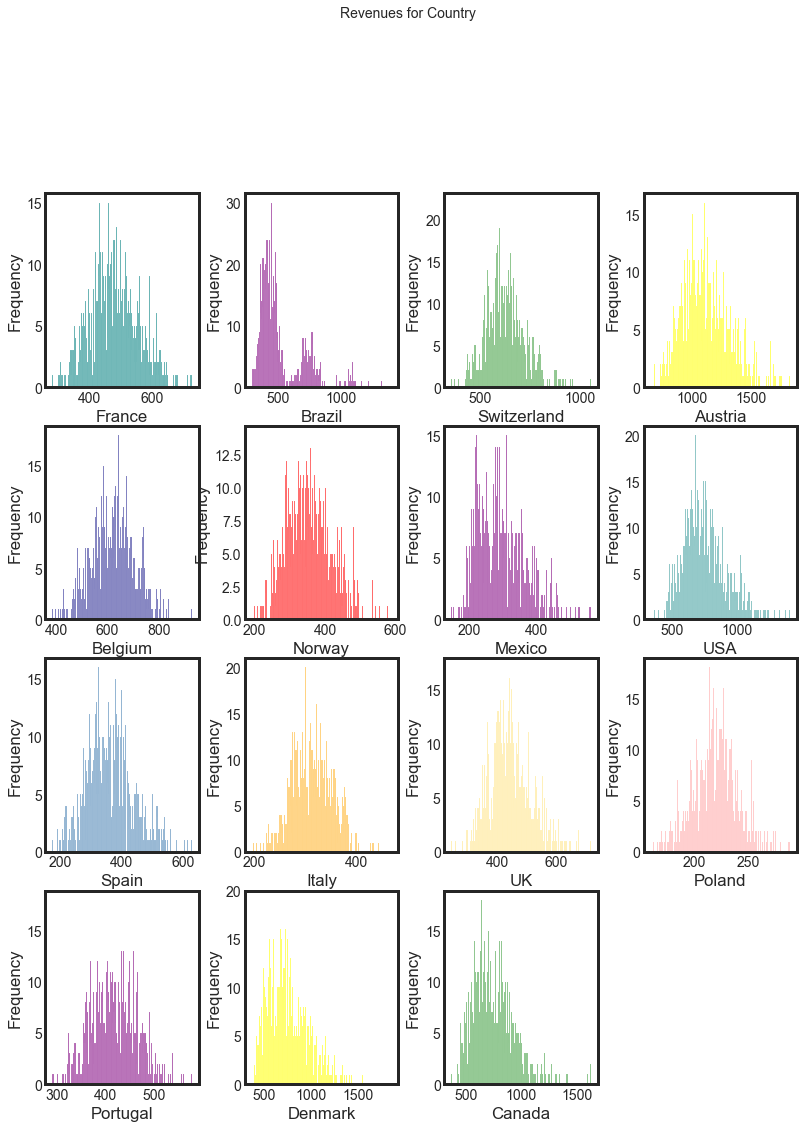

In [41]:
fig = plt.figure(figsize = (12,20))
title = fig.suptitle("Revenues for Country", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(5,4, 1)
ax.set_xlabel("France")
ax.set_ylabel("Frequency") 
plt.hist(france_sampling, bins=250, color = 'teal', lw=.1,label = 'France',alpha =0.61)        

ax = fig.add_subplot(5,4, 2)
ax.set_xlabel("Brazil")
ax.set_ylabel("Frequency") 
plt.hist(brazil_sampling, bins=250, color = 'purple',lw=.1, label = 'Brazil ',alpha =0.61)

ax = fig.add_subplot(5,4, 3)
ax.set_xlabel("Switzerland")
ax.set_ylabel("Frequency") 
plt.hist(switzerland_sampling, bins=250, color = 'green',lw=.1, label = 'Switzerland',alpha =0.451)


ax = fig.add_subplot(5,4, 4)
ax.set_xlabel("Austria")
ax.set_ylabel("Frequency") 
plt.hist(austria_sampling , bins =250, color = 'yellow',lw=.1, label = 'Austria',alpha =0.61)

ax = fig.add_subplot(5,4, 5)
ax.set_xlabel("Belgium")
ax.set_ylabel("Frequency") 
plt.hist(belgium_sampling, bins= 250, color = 'navy',lw=.1, label = 'Belgium',alpha =0.51)

ax = fig.add_subplot(5,4, 6)
ax.set_xlabel("Norway")
ax.set_ylabel("Frequency") 
plt.hist(norway_sampling , bins =250, color = 'red',lw=.1, label = 'Norway',alpha =0.61)

ax = fig.add_subplot(5,4, 7)
ax.set_xlabel("Mexico")
ax.set_ylabel("Frequency") 
plt.hist(mexico_sampling, bins=250, color = 'purple',lw=.1, label = 'Mexico ',alpha =0.61)


ax = fig.add_subplot(5,4, 8)
ax.set_xlabel("USA")
ax.set_ylabel("Frequency") 
plt.hist(usa_sampling, bins=250, color = 'teal',lw=.1, label = 'USA',alpha =0.451)

ax = fig.add_subplot(5,4, 9)
ax.set_xlabel("Spain")
ax.set_ylabel("Frequency") 
plt.hist(spain_sampling , bins =250, color = 'steelblue',lw=.1, label = 'Spain',alpha =0.61)

ax = fig.add_subplot(5,4, 10)
ax.set_xlabel("Italy")
ax.set_ylabel("Frequency") 
plt.hist(italy_sampling, bins= 250, color = 'orange',lw=.1, label = 'Italy',alpha =0.51)

ax = fig.add_subplot(5,4, 11)
ax.set_xlabel("UK")
ax.set_ylabel("Frequency") 
plt.hist(uk_sampling , bins =250, color = ('#FFE888', ),lw=.1, label = 'UK',alpha =0.61)


ax = fig.add_subplot(5,4, 12)
ax.set_xlabel("Poland")
ax.set_ylabel("Frequency") 
plt.hist(poland_sampling, bins= 250, color = '#FF9999',lw=.1, label = 'Poland',alpha =0.51)




ax = fig.add_subplot(5,4, 13)
ax.set_xlabel("Portugal")
ax.set_ylabel("Frequency") 
plt.hist(portugal_sampling, bins=250, color = 'purple',lw=.1,  label = 'Portugal ',alpha =0.61)

ax = fig.add_subplot(5,4, 14)
ax.set_xlabel("Denmark")
ax.set_ylabel("Frequency") 

plt.hist(denmark_sampling , bins =250, color = 'yellow',lw=.1 ,label = 'Denmark',alpha =0.61)

ax = fig.add_subplot(5,4, 15)
ax.set_xlabel("Canada")
ax.set_ylabel("Frequency") 
plt.hist(canada_sampling, bins=250, color = 'green',lw=.1, label = 'Canada',alpha =0.451)

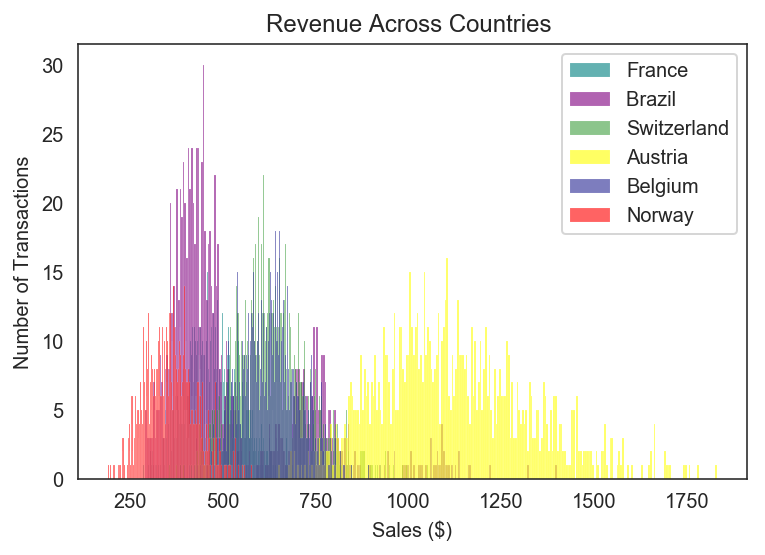

In [246]:
#Visualize Distribution of Average value of transactions
plt.hist(france_sampling, bins=250, color = 'teal', lw=.1,label = 'France',alpha =0.61)
plt.hist(brazil_sampling, bins=250, color = 'purple',lw=.1, label = 'Brazil ',alpha =0.61)
plt.hist(switzerland_sampling, bins=250, color = 'green',lw=.1, label = 'Switzerland',alpha =0.451)
plt.hist(austria_sampling , bins =250, color = 'yellow',lw=.1, label = 'Austria',alpha =0.61)
plt.hist(belgium_sampling, bins= 250, color = 'navy',lw=.1, label = 'Belgium',alpha =0.51)
plt.hist(norway_sampling , bins =250, color = 'red',lw=.1, label = 'Norway',alpha =0.61)




plt.title('Revenue Across Countries ')
plt.legend()
plt.xlabel('Sales ($)')
plt.ylabel('Number of Transactions')
plt.show()


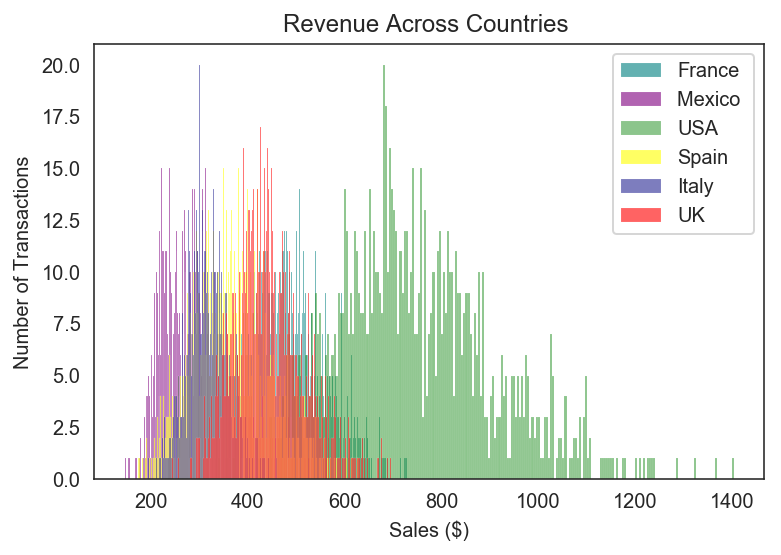

In [241]:
#Visualize Distribution of Average value of transactions
plt.hist(france_sampling, bins=250, color = 'teal', lw=.1,label = 'France',alpha =0.61)
plt.hist(mexico_sampling, bins=250, color = 'purple',lw=.1, label = 'Mexico ',alpha =0.61)
plt.hist(usa_sampling, bins=250, color = 'green',lw=.1, label = 'USA',alpha =0.451)
plt.hist(spain_sampling , bins =250, color = 'yellow',lw=.1, label = 'Spain',alpha =0.61)
plt.hist(italy_sampling, bins= 250, color = 'navy',lw=.1, label = 'Italy',alpha =0.51)
plt.hist(uk_sampling , bins =250, color = 'red',lw=.1, label = 'UK',alpha =0.61)



plt.title('Revenue Across Countries ')
plt.legend()
plt.xlabel('Sales ($)')
plt.ylabel('Number of Transactions')
plt.show()




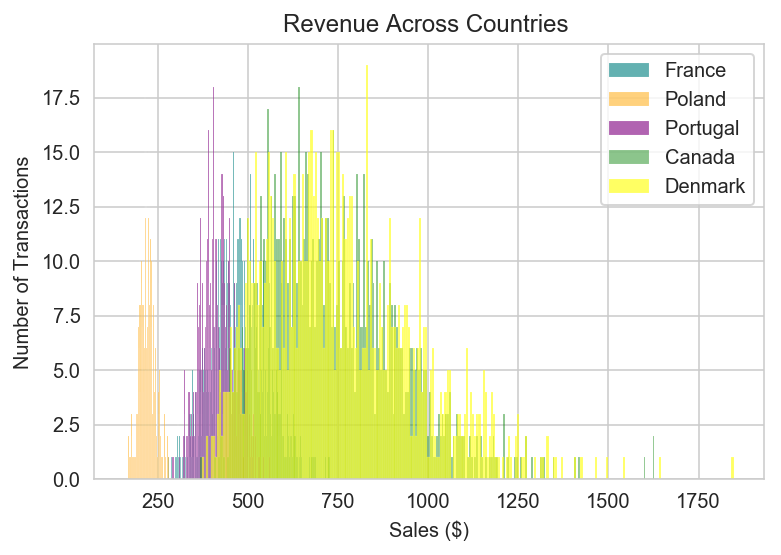

In [331]:

#Visualize Distribution of Average value of transactions
plt.hist(france_sampling, bins=250, color = 'teal', lw=.1,label = 'France',alpha =0.61)
plt.hist(poland_sampling, bins= 250, color = 'orange',lw=.1, label = 'Poland',alpha =0.51)
plt.hist(portugal_sampling, bins=250, color = 'purple',lw=.1, label = 'Portugal ',alpha =0.61)
plt.hist(canada_sampling, bins=250, color = 'green',lw=.1, label = 'Canada',alpha =0.451)
plt.hist(denmark_sampling , bins =250, color = 'yellow',lw=.1, label = 'Denmark',alpha =0.61)



plt.title('Revenue Across Countries ')
plt.legend()
plt.xlabel('Sales ($)')
plt.ylabel('Number of Transactions')
plt.show()





In [2]:
#Null Hypothosis revenue between products will be appproximately equal 
#Alternative Some Products will generate dispropiately different revenues 
#Query of Product Transactions and Organization of DataFrames



hyp4 = pd.DataFrame()
hyp4 = pd.read_sql_query('SELECT*  FROM Category cat JOIN Product pro ON cat.Id = pro.id JOIN [OrderDetail] od ON pro.Id = od.ProductId ', engine)
hyp4_df = pd.DataFrame()
hyp4_df['Category'] = hyp4['CategoryName']
hyp4_df = pd.concat([hyp4_df, hyp4['UnitPrice'],hyp4['Quantity']], axis =1)
hyp4_df['Revenue']= hyp4_df.iloc[:,2]*hyp4_df.iloc[:,3]
hyp4_df= hyp4_df.drop(['UnitPrice','Quantity'], axis = 1)

g_c = hyp4_df.loc[hyp4_df['Category']== 'Grains/Cereals' ]
cdm = hyp4_df.loc[hyp4_df['Category']== 'Condiments' ]
cft = hyp4_df.loc[hyp4_df['Category']== 'Confections' ]
pro = hyp4_df.loc[hyp4_df['Category']== 'Produce' ]
bev = hyp4_df.loc[hyp4_df['Category']== 'Beverages' ]
dai = hyp4_df.loc[hyp4_df['Category']== 'Dairy Products' ]
m_p = hyp4_df.loc[hyp4_df['Category']== 'Meat/Poultry' ]
sea = hyp4_df.loc[hyp4_df['Category']== 'Seafood' ]

2019-04-12 17:24:49,814 INFO sqlalchemy.engine.base.Engine SELECT*  FROM Category cat JOIN Product pro ON cat.Id = pro.id JOIN [OrderDetail] od ON pro.Id = od.ProductId 
2019-04-12 17:24:49,815 INFO sqlalchemy.engine.base.Engine ()


In [3]:
#Sampling of Product Transactions to equalize number of transactions
gc_smp =[]
cdm_smp=[]
cft_smp=[]
pro_smp=[]
bev_smp=[]
dai_smp=[]
mp_smp=[]
sea_smp =[]
control= []
for i in range(0,1000):
    np.random.seed(i)
    g_s =g_c.Revenue.sample(n=50, replace= True, random_state = i, )
    cds =cdm.Revenue.sample(n=50, replace= True, random_state = i, )
    cfs =cft.Revenue.sample(n=50, replace= True, random_state = i, )
    prs = pro.Revenue.sample(n=50, replace= True, random_state = i, )
    bes = bev.Revenue.sample(n=50, replace= True, random_state = i, )
    dais= dai.Revenue.sample(n=50, replace= True, random_state = i, )
    mps = m_p.Revenue.sample(n=50, replace= True, random_state = i, )
    seas= sea.Revenue.sample(n=50, replace= True, random_state = i, )
    contr = hyp4_df.Revenue.sample(n=50, replace= True, random_state = i, )
    gc_smp.append(g_s.mean())
    cdm_smp.append(cds.mean())
    cft_smp.append(cfs.mean())
    pro_smp.append(prs.mean())
    bev_smp.append(bes.mean())
    dai_smp.append(dais.mean())
    mp_smp.append(mps.mean())
    sea_smp.append(seas.mean())
    control.append(contr.mean())

In [4]:
#Numpy arrays for Analysis 
grains = np.asarray(gc_smp)
seafood = np.asarray(sea_smp)
meat = np.asarray(mp_smp)
dairy = np.asarray(dai_smp)
beverage = np.asarray(bev_smp)
produce = np.asarray(pro_smp)
bake_goods = np.asarray(cft_smp)
condiments = np.asarray(cdm_smp)
rev = np.asarray(control)

In [6]:
#Analysis of Variance
data= {'Control': rev,'Grains': grains, 'Seafood': seafood, 'Dairy': dairy, 'Beverage':beverage, 'Produce':produce, 'Bake_Goods': bake_goods, 'Condiments': condiments  }
df = pd.DataFrame.from_dict(data)
formula = 'Control ~ Grains +Seafood + Dairy + Beverage + Produce + Bake_Goods + Condiments'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)
#print('The final column PR(>F) corresponds to the p-value in relationship to a random sampling of all categories, the product that stands out the most is Seafoood, with an honorable mention of Condiments.'
#print(' which is also observed in the graph above, where the null hypothosis can be rejected and the alternative hypothosis sticks')      

                  sum_sq     df         F    PR(>F)
Grains      5.390013e+01    1.0  0.012523  0.910922
Seafood     3.341904e+04    1.0  7.764279  0.005431
Dairy       1.330342e+04    1.0  3.090795  0.079045
Beverage    4.548306e+02    1.0  0.105671  0.745196
Produce     1.983476e+02    1.0  0.046082  0.830070
Bake_Goods  8.398340e+01    1.0  0.019512  0.888937
Condiments  2.453346e+04    1.0  5.699882  0.017152
Residual    4.269771e+06  992.0       NaN       NaN


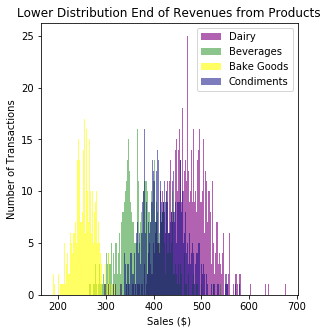

In [7]:



plt.figure(figsize = (4.6, 5))
ax = plt.gca()
ax.set_facecolor('xkcd:white')
#plt.hist(grains, bins=250 , color = 'red', lw=.7, label = 'Grains',alpha =0.41)
#plt.hist(seafood, bins=250, color = 'blue', lw=.7,label = 'Seafood',alpha =0.61)
#plt.hist(meat, bins=250, color = 'orange', lw=.7,label= 'Meat',alpha =0.61)
plt.hist(dairy, bins=250, color = 'purple',lw=.7, label = 'Dairy ',alpha =0.61)
plt.hist(beverage, bins=250, color = 'green',lw=.7, label = 'Beverages',alpha =0.451)
plt.hist(bake_goods , bins =250, color = 'yellow',lw=.7, label = 'Bake Goods',alpha =0.61)
plt.hist(condiments, bins= 250, color = 'navy',lw=.7, label = 'Condiments',alpha =0.51)
#plt.hist(produce, bins=250, color = 'gray', lw=.7,label = 'Produce',alpha =0.51)
#plt.hist(rev, bins=250, color = 'black', label = 'Control', alpha = 0.3)
plt.title('Lower Distribution End of Revenues from Products')
plt.legend()
plt.xlabel('Sales ($)')
plt.ylabel('Number of Transactions')
plt.show()


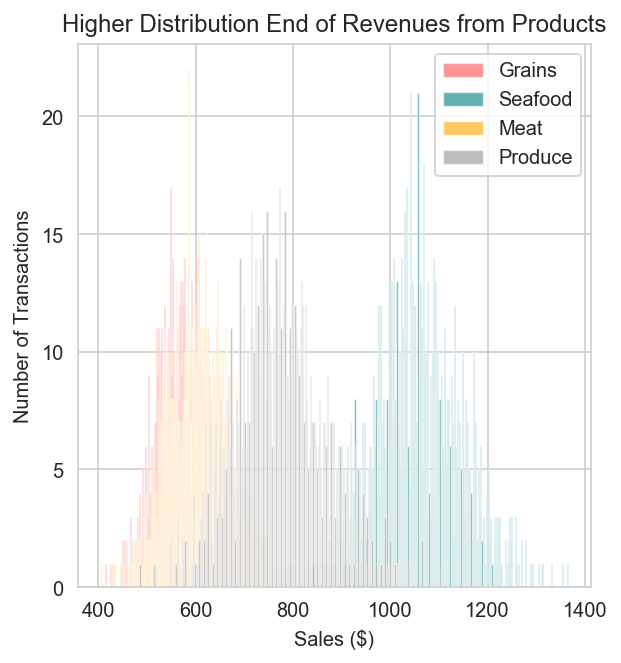

In [333]:
plt.figure(figsize = (4.6, 5))
ax = plt.gca()
ax.set_facecolor('xkcd:white')
plt.hist(grains, bins=250 , color = 'red', lw=.7, label = 'Grains',alpha =0.41)
plt.hist(seafood, bins=250, color = 'teal', lw=.7,label = 'Seafood',alpha =0.61)
plt.hist(meat, bins=250, color = 'orange', lw=.7,label= 'Meat',alpha =0.61)
#plt.hist(dairy, bins=250, color = 'purple',lw=.7, label = 'Dairy ',alpha =0.61)
#plt.hist(beverage, bins=250, color = 'green',lw=.7, label = 'Beverages',alpha =0.451)
#plt.hist(bake_goods , bins =250, color = 'yellow',lw=.7, label = 'Bake Goods',alpha =0.61)
#plt.hist(condiments, bins= 250, color = 'navy',lw=.7, label = 'Condiments',alpha =0.51)
plt.hist(produce, bins=250, color = 'gray', lw=.7,label = 'Produce',alpha =0.51)
#plt.hist(rev, bins=250, color = 'black', label = 'Control', alpha = 0.3)
plt.title('Higher Distribution End of Revenues from Products')
plt.legend()
plt.xlabel('Sales ($)')
plt.ylabel('Number of Transactions')
plt.show()



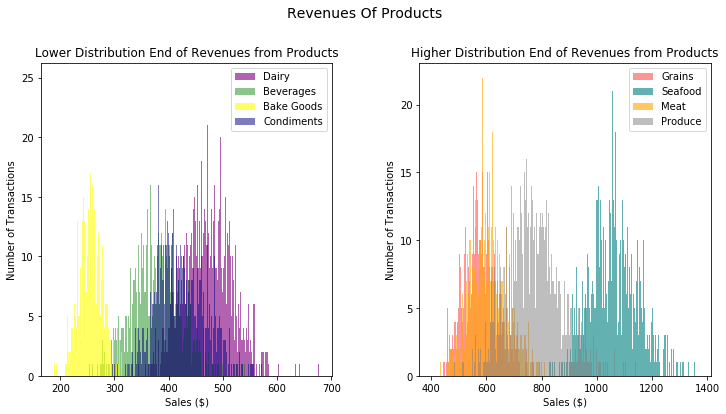

In [10]:
#Created for Walk Though
fig = plt.figure(figsize = (12,6))
title = fig.suptitle("Revenues Of Products", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1,2, 2)
ax = plt.gca()
ax.set_facecolor('xkcd:white')

plt.hist(grains, bins=250 , color = 'red', lw=.7, label = 'Grains',alpha =0.41)
plt.hist(seafood, bins=250, color = 'teal', lw=.7,label = 'Seafood',alpha =0.61)
plt.hist(meat, bins=250, color = 'orange', lw=.7,label= 'Meat',alpha =0.61)
plt.hist(produce, bins=250, color = 'gray', lw=.7,label = 'Produce',alpha =0.51)

plt.title('Higher Distribution End of Revenues from Products')
plt.legend()
plt.xlabel('Sales ($)')
plt.ylabel('Number of Transactions')


ax = fig.add_subplot(1,2, 1)
ax = plt.gca()
ax.set_facecolor('xkcd:white')

plt.hist(dairy, bins=250, color = 'purple',lw=.7, label = 'Dairy ',alpha =0.61)
plt.hist(beverage, bins=250, color = 'green',lw=.7, label = 'Beverages',alpha =0.451)
plt.hist(bake_goods , bins =250, color = 'yellow',lw=.7, label = 'Bake Goods',alpha =0.61)
plt.hist(condiments, bins= 250, color = 'navy',lw=.7, label = 'Condiments',alpha =0.51)

plt.title('Lower Distribution End of Revenues from Products')
plt.legend()
plt.xlabel('Sales ($)')
plt.ylabel('Number of Transactions')

plt.show()

2019-03-26 18:27:36,767 INFO sqlalchemy.engine.base.Engine SELECT*  FROM Category cat JOIN Product pro ON cat.Id = pro.id JOIN [OrderDetail] od ON pro.Id = od.ProductId JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id 
2019-03-26 18:27:36,768 INFO sqlalchemy.engine.base.Engine ()
countries 20 cities 50


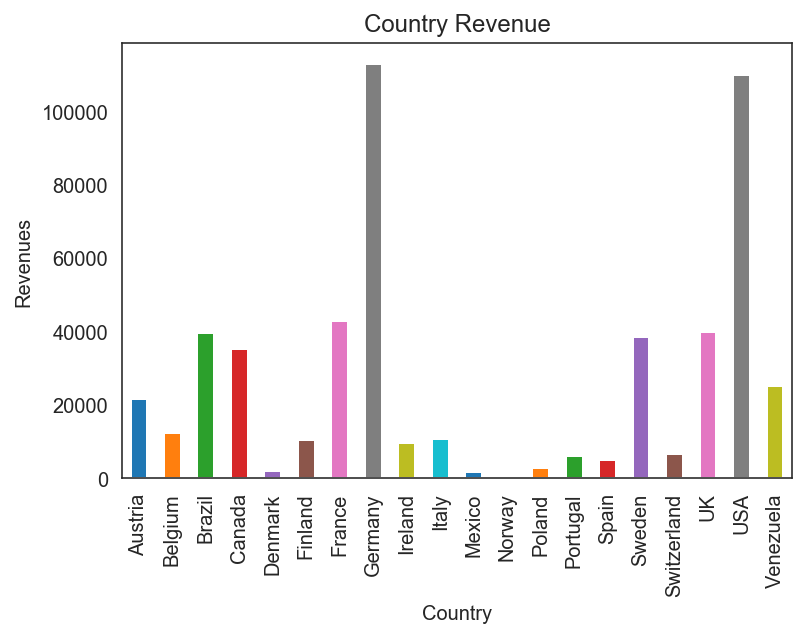

In [309]:
#Created For Visulization of Total Revenues
h3 = pd.read_sql_query("SELECT*  FROM Category cat JOIN Product pro ON cat.Id = pro.id JOIN [OrderDetail] od ON pro.Id = od.ProductId JOIN [Order] o ON od.OrderId = o.Id JOIN Customer cus ON o.CustomerId = cus.Id ", engine)


cats_cus_df = pd.DataFrame()
cats_cus_df['Category']= h3['CategoryName']
cats_cus_df['Revenue'] = h3.iloc[:,16]*h3.iloc[:,17]
cats_cus_df['City'] = h3.iloc[:, 38]
cats_cus_df['Country']= h3.iloc[:,41]
n_countries = len(cats_cus_df['Country'].unique())
n_cities = len(cats_cus_df['City'].unique())
print(f'countries {n_countries} cities {n_cities}' )
cats_cus_df.head()
#Create a random population of Countries, Cities, Revenues, Categories
def create_sample():
    x = np.linspace(0,169, 170)
    columns = ["Category", "Revenue", "City", "Country"]
    sample_df= pd.DataFrame(columns = columns)
    for i in range(1,1000):
        row_selector = (np.random.choice((x),size = 1, replace = True))
        row_selector = int(row_selector - row_selector%1)
        sample_df.loc[i] = cats_cus_df.loc[row_selector]
    

#Create a distribtion of 
city_revenues = sample_df.groupby('Country')['Revenue']
sum_city_revenues = sample_df.groupby('Country')['Revenue'].sum()
plt.ylabel('Revenues')
sum_city_revenues.plot.bar(title = 'Country Revenue')




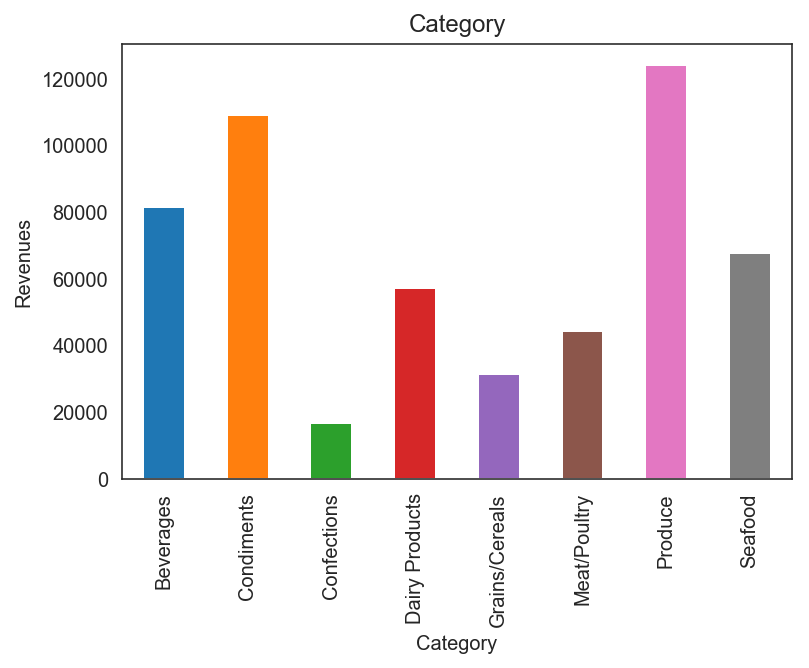

In [310]:
#Create a distribution of Revenues Over Categories For Visualization
sum_city_category = sample_df.groupby('Category')['Revenue'].sum()
plt.ylabel('Revenues')
sum_city_category.plot.bar(title = 'Category')